**Проект**: Сервис предоставления услуг с возможностью оплаты на сайте

**Контекст**: 
В ходе исследования поведения пользователей, было принято решение об изменении механики оплаты

**Задача**: 
Проверить влияние новой механики оплаты на метрики. Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

**Разделы исследования** <a id='stepend'></a>

- [Проведение первичного анализа данных](#step1)
- [Анализ датарейма с оплатами, выявление выбросов](#step2)
- [Промежуточные выводы](#step3)
- [Просмотр характеристик получившихся датафреймов](#step4)
- [Исследование данных на соответствие нормальному распределению](#step5)
- [Исследование CR](#step6)
- [Исследование среднего чека (ARPU)](#step7)
- [Исследование среднего чека среди платящих пользователей (ARPPU)](#step8)
- [Выводы из анализа](#step9)

### `1. Импортируем необходимые библиотеки`


In [6]:
import pandas as pd
import numpy as np
import pingouin as pg
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import kstest

### `2. Загрузим необходимые файлы для работы`

2.1 Загрузим данные с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)

In [7]:
tab_groups = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-ilenkov/Финальный проект/2_Вариант/Проект_2_groups.csv', sep=";")

In [8]:
tab_groups.head(5)

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


2.2 Загрузим дополнительные данные с пользователями, который прислали спустя 2 дня после передачи данных

In [9]:
tab_groups_add = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-ilenkov/Финальный проект/2_Вариант/Проект_2_group_add.csv', sep=",")

In [10]:
tab_groups_add.head(5)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


2.3 Загрузим данные с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.

In [11]:
tab_active_studs = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-ilenkov/Финальный проект/2_Вариант/Проект_2_active_studs.csv')

In [12]:
tab_active_studs = tab_active_studs.rename(columns={"student_id": "id"})

In [13]:
tab_active_studs.head(5)

,id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


2.4 Загрузим данные с информацией об оплатах пользователей в дни проведения эксперимента

In [14]:
tab_checks = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-ilenkov/Финальный проект/2_Вариант/Проект_2_checks.csv', sep=";")

In [17]:
tab_checks = tab_checks.rename(columns={"student_id": "id"})

In [18]:
tab_checks.head(5)

,id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


### `3. Проведем первичный анализ данных` <a id="step1"></a>


#### 3.1 Данные с информацией о принадлежности пользователя к контрольной или экспериментальной группе

> Применим функцию .info для получения информации о типе данных, кол-ве строк, кол-ве пустых значений

In [19]:
tab_groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


>**Комментарий**: *Всего строк 74484, тип у данных присвоен корректный (числовой у чисел, текстовый у текстовых), пустых значений нет*

> Применим функцию .nunique() для расчета кол-ва уникальных значений

In [20]:
tab_groups.id.nunique()

74484

>**Комментарий**: *Каждое значение уникально, дубликатов нет*

> Применим функцию .isna() и .sum() для расчета кол-ва пропущенных

In [21]:
tab_groups.isna().sum()

id     0
grp    0
dtype: int64

>**Комментарий**: *Пропущенных значений нет*

> Применим функцию .loc чтобы удостоверится в том, что нет дубликатов

In [22]:
tab_groups.loc[tab_groups.duplicated()]

,id,grp


#### 3.2 Данные с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.

> Применим функцию .info для получения информации о типе данных, кол-ве строк, кол-ве пустых значений


In [23]:
tab_groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


>**Комментарий**: *Всего строк 92, тип у данных присвоен корректный (числовой у чисел, текстовый у текстовых), пустых значений нет*

In [24]:
tab_groups_add.id.nunique()

92

>**Комментарий**: *Каждое значение уникально, дубликатов нет*

> Применим функцию .isna() и .sum() для расчета кол-ва пропущенных


In [25]:
tab_groups_add.isna().sum()

id     0
grp    0
dtype: int64

>**Комментарий**: *Пропущенных значений нет*

> Применим функцию .loc чтобы удостоверится в том, что нет дубликатов


In [26]:
tab_groups.loc[tab_groups.duplicated()]

,id,grp


#### 3.3 Данные с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.

> Применим функцию .info для получения информации о типе данных, кол-ве строк, кол-ве пустых значений


In [27]:
tab_active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


>**Комментарий**: *Всего строк 8341, тип у данных присвоен корректный (числовой у чисел, текстовый у текстовых), пустых значений нет*

> Применим функцию .nunique() для расчета кол-ва уникальных значений

In [28]:
tab_active_studs.id.nunique()

8341

>**Комментарий**: *Каждое значение уникально, дубликатов нет*

> Применим функцию .isna() и .sum() для расчета кол-ва пропущенных

In [29]:
tab_active_studs.loc[tab_active_studs.duplicated()]

,id


>**Комментарий**: *Пропущенных значений нет*

#### 3.4 Данные с информацией об оплатах пользователей в дни проведения эксперимента

> Применим функцию .info для получения информации о типе данных, кол-ве строк, кол-ве пустых значений

In [30]:
tab_checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      541 non-null    int64  
 1   rev     541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


>**Комментарий**: *Всего строк 541, тип у данных присвоен корректный (числовой у чисел, текстовый у текстовых), пустых значений нет*

> Применим функцию .isna() и .sum() для расчета кол-ва пропущенных*

In [31]:
tab_checks.isna().sum()

id     0
rev    0
dtype: int64

>**Комментарий**: *Пропущенных значений нет*


> Применим функцию .loc чтобы удостоверится в том, что нет дубликатов

In [32]:
tab_checks.loc[tab_checks.duplicated()]

,id,rev


>**Комментарий**: *Дубликатов нет*

#### 3.5 Исследуем, есть ли такие пользователи, которые купили, но не заходили на платформу в дни проведения эксперимента

3.5.1  Соединим два датафрейма groups и groups_add

In [33]:
all_groups = pd.concat([tab_groups, tab_groups_add], ignore_index=True, sort=False)


In [34]:
all_groups.head(5)

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


3.5.2 Создадим колонку, в которой будет статус каждого пользователя. False - такого id нет в таблице активных пользователей. True - id есть в таблице активных пользователей

>**Комментарий**: *Используем функцию из библиотеки numpy, - проверяем, есть ли id из all_groups в таблице Id активных пользователей*

In [35]:
all_groups['contain'] = np.isin(all_groups['id'],tab_active_studs['id'])


In [36]:
all_groups.head(5)

,id,grp,contain
0,1489,B,False
1,1627,A,True
2,1768,B,False
3,1783,B,False
4,1794,A,False


3.5.3 Соединим получившуюся таблицу с данными по оплатам

In [37]:
all_pay = all_groups.merge(tab_checks, on='id', how='left')

In [38]:
all_pay

,id,grp,contain,rev
0,1489,B,False,NaN
1,1627,A,True,990.0
2,1768,B,False,NaN
3,1783,B,False,NaN
4,1794,A,False,NaN
...,...,...,...,...
74571,200247820,B,False,NaN
74572,201032527,B,False,NaN
74573,201067612,B,False,NaN
74574,201067653,B,False,NaN


3.5.4 Заполним нулевым значением те строки, где у id отсутствует оплата

In [39]:
all_pay = all_pay.fillna(0)

In [40]:
all_pay

,id,grp,contain,rev
0,1489,B,False,0.0
1,1627,A,True,990.0
2,1768,B,False,0.0
3,1783,B,False,0.0
4,1794,A,False,0.0
...,...,...,...,...
74571,200247820,B,False,0.0
74572,201032527,B,False,0.0
74573,201067612,B,False,0.0
74574,201067653,B,False,0.0


3.5.5 Рассчитаем, сколько пользователей, которые не яв-ся активными, но у них есть оплата

In [41]:
all_pay.query('contain == False & rev > 0').id.count()

149

In [42]:
all_pay.query('contain == True & rev > 0').id.count()

392

3.5.6 Сколько процентов таких пользвоателей (не яв-ся активными, но у них есть оплата)

In [43]:
(all_pay.query('contain == False & rev > 0').id.count() / all_pay.query('contain == True & rev > 0').id.count()) * 100

38.01020408163265

>**Комментарий**: *На данный момент у нас 149 пользователей, которые не заходили в приложение в период проведения эксперимента, но производили оплату и это составялет порядка 38%*


>**Комментарий**: *На какой-то особый случай оплаты, - через менеджера, почтовым уведомлением не похоже - вероятнее всего ошибка*


> Выделим отдельно этих пользователей

In [44]:
without_pay = all_pay.query('contain == False & rev > 0')

In [45]:
without_pay

,id,grp,contain,rev
39,3185,B,False,690.0
121,25973,B,False,690.0
125,26280,B,False,690.0
223,100645,B,False,630.0
254,102534,B,False,580.0
...,...,...,...,...
72452,5291900,B,False,199.0
72753,5331842,B,False,290.0
73632,5486319,B,False,199.0
74049,5562806,B,False,398.0


3.6 Посмотрим, с чем может быть связана такая ситуация, указанная в п.3.5.5

3.6.1  Узнаем, сколько таких пользователей в таблице groups

In [46]:
test_groups = tab_groups.copy()

In [47]:
test_groups['status'] = np.isin(test_groups['id'],without_pay['id'])

In [48]:
test_groups.query('status=="False"').id.count()


0

>**Комментарий**: *Пользователи, которые не заходили в приложение в период проведения эксперимента, но производили оплату не обнаружены в таблице id с присвоенными группами

3.6.2  Узнаем, сколько таких пользователей в таблице groups_add, т.е которых прислали спустя 2 дня после передачи данных

In [49]:
test_groups_add = tab_groups_add.copy()

In [50]:
test_groups_add['status'] = np.isin(test_groups_add['id'],without_pay['id'])

In [51]:
test_groups_add.query('status=="False"').id.count()


0

>**Комментарий**: *Среди пользователей, которых добавили спустя 2 дня, которые не заходили в приложение в период проведения эксперимента, но производили оплату не обнаружены в таблице id с присвоенными группами


3.7  Добавим к таблице с активными пользователями недостающие id (т.е тех, кто оплатил в период проведения эксперимента, но не попал в активных пользователей)

In [52]:
tab_active_studs = pd.concat([tab_active_studs, without_pay], ignore_index=True, sort=False)

In [53]:
tab_active_studs = tab_active_studs.id

In [54]:
tab_active_studs

0        581585
1       5723133
2       3276743
3       4238589
4       4475369
         ...   
8485    5291900
8486    5331842
8487    5486319
8488    5562806
8489    5599663
Name: id, Length: 8490, dtype: int64

>**Комментарий**: *Изначально таблица с активными пользователями содержала 8341 id, после добавления 149 - 8490 - все верно - ошибка исправлена


### `4. Датафрейм с данными о принадлежности пользователя к группам экспериментальной группе`


>**Комментарий**: *Нас интересует эксперимент и участвовавшие в нем пользователи, в конечном счете мы должны сформировать два датафрема с максимально "чистыми" данными, которые будут включать в себя активных пользователей двух групп*


4.1 Применим функцию .concat чтобы соеденить основную таблицу и дополнительные данные и добавим функцию, чтобы удалить дубликаты в случае дулирования в добавленном файле информации удостоверится в том, что нет дубликатов

In [55]:
tab_group_all = pd.concat([tab_groups,tab_groups_add]).drop_duplicates().reset_index(drop=True)

In [56]:
tab_group_all

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


**Важный датафрейм** Здесь данные всех пользователей - tab_group_all

**Комментарий**: *Дубликатов в добавленной информации не было. Это было необходимо сделать, т.к вдруг на этом этапе возникла ошибка и один и тот же id попал и в группу А и в группу В.*

> Применим функцию .isna().sum() для того, чтобы проверить кол-во пропущенных значений

In [57]:
tab_group_all.isna().sum()

id     0
grp    0
dtype: int64

>**Комментарий**: *Пропущенные значения отсутсвуют*


### `5  Посмотрим на параметры датафрейма tab_checks` <a id="step2"></a>

>**Комментарий**: *Все исследование в конечном счете сведется к тому, как влияет новая функциональность на генерирование дохода и важно посмотреть, есть ли выбросы в данных, какое среднее значение*

5.1 Найдем максимальное, минимальное, сренее и медианное значение

In [58]:
print('Максимальное значение в датафрейме tab_checks равняется:', tab_checks.rev.max())
print('Минимальное значение в датафрейме tab_checks равняется:', tab_checks.rev.min())
print('Среднее значение в датафрейме tab_checks равняется:', tab_checks.rev.mean().round(3))
print('Медианное значение в датафрейме tab_checks равняется:', tab_checks.rev.median())

Максимальное значение в датафрейме tab_checks равняется: 4650.0
Минимальное значение в датафрейме tab_checks равняется: 199.0
Среднее значение в датафрейме tab_checks равняется: 1059.752
Медианное значение в датафрейме tab_checks равняется: 840.0


5.2 Построим .boxplot и посмотрим на то, как распределены числовые переменные

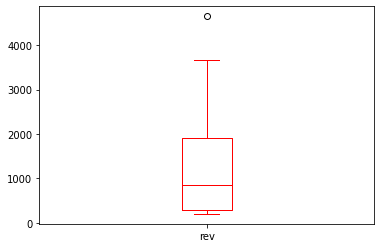

In [59]:
tab_checks.boxplot(column=['rev'], grid= False , color='red')


>**Комментарий**: *Как видим, есть какое-то значение, которые сильно выходит за "усики" максимального значения*

5.3 Применим к датафрейму метод межвартильного размаха для удаления выброса и посмотрим как в этом случае изменятся показатели

5.3.1 Найдем пороговое значение 25% квантиля


In [60]:
q1 = tab_checks.quantile(q=.25)

In [61]:
q1

id     987129.0
rev       290.0
Name: 0.25, dtype: float64

5.3.2 Найдем пороговое значение 75% квантиля


In [62]:
q3 = tab_checks.quantile(q=.75)

In [63]:
q3

id     3993249.0
rev       1900.0
Name: 0.75, dtype: float64

5.3.3 Найдем межквартильный размах


In [64]:
iqr = tab_checks.apply(stats.iqr)

5.3.4 Удалим выброс


In [65]:
data_clean = tab_checks[~((tab_checks < (q1-1.5*iqr)) | (tab_checks > (q3+1.5*iqr))).any(axis=1)]

In [66]:
data_clean.shape

(540, 2)

In [67]:
data_clean.rev.max()

3660.0

>**Комментарий**: *Как видим, удалено одно значение в rev в 4650.0*

In [68]:
print('Максимальное значение в датафрейме tab_checks равняется:', data_clean.rev.max())
print('Минимальное значение в датафрейме tab_checks равняется:', data_clean.rev.min())
print('Среднее значение в датафрейме tab_checks равняется:', data_clean.rev.mean().round(3))
print('Медианное значение в датафрейме tab_checks равняется:', data_clean.rev.median())

Максимальное значение в датафрейме tab_checks равняется: 3660.0
Минимальное значение в датафрейме tab_checks равняется: 199.0
Среднее значение в датафрейме tab_checks равняется: 1053.104
Медианное значение в датафрейме tab_checks равняется: 840.0


5.4 Посмотрим, сколько продаж в каждом "размере" покупки

In [69]:
quantity_points = tab_checks.groupby('rev').agg({'id':'count'}).sort_values(by = 'id', ascending=False).reset_index()

In [70]:
quantity_points

,rev,id
0,1900.0000,97
1,290.0000,94
2,690.0000,78
3,199.0000,46
4,990.0000,41
5,1900.0001,36
6,840.0000,27
7,1140.0000,25
8,580.0000,15
9,590.0000,11


>**Комментарий**: *Показатели не сильно различаются в сравнении данных до удаления этого значения. Этот id пользователя принадлежит активным пользователям группы А - т.е он в контрольной группе. Просто единичный случай, которого может никогда и не быть.* **'id == "445767"'** - нетипичное наблюдение, но я его оставлю и рассмотрю все с ним - вряд ли оно повлияет как-то на результат.

### 6. Создадим датафрейм с активными пользователями, заходившими на платформу в дни экперимента с информацией о принадлежности к группе


In [71]:
tab_active_studs = tab_active_studs.reset_index()

In [72]:
tab_active_all = tab_active_studs.merge(tab_group_all, how='left', on='id')

In [73]:
tab_active_all

,index,id,grp
0,0,581585,A
1,1,5723133,A
2,2,3276743,B
3,3,4238589,A
4,4,4475369,B
...,...,...,...
8485,8485,5291900,B
8486,8486,5331842,B
8487,8487,5486319,B
8488,8488,5562806,B


>**Комментарий**: *Т.е я соединил две таблицы, - всех пользователей присоеденил к активным пользователям, чтобы была информация о группе (А или B)*

6.1 Посмотрим, как распределены пользователи по группам

In [74]:
quantity_users = tab_active_all.groupby('grp').agg({'id':'count'}).rename(columns={"id": "quantity"}).reset_index()

In [75]:
quantity_users

,grp,quantity
0,A,1567
1,B,6923


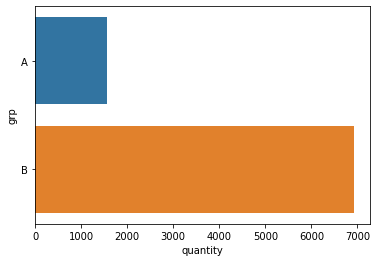

In [76]:
ax = sns.barplot(data=quantity_users, y='grp', x='quantity')


In [77]:
more_than = (6803 / 1538)
print('Пользователей в группе B больше чем в группе А на:', more_than )
print('Выглядит странно, не похоже что распределение на группы стремилось к балансу')

Пользователей в группе B больше чем в группе А на: 4.423276983094929
Выглядит странно, не похоже что распределение на группы стремилось к балансу


### `7. Добавим к датафрейму с активными пользователями и группой информацию о платежах`

In [78]:
tab_active_all = tab_active_all.merge(tab_checks, how='left', on='id')

In [79]:
tab_active_all

,index,id,grp,rev
0,0,581585,A,NaN
1,1,5723133,A,NaN
2,2,3276743,B,NaN
3,3,4238589,A,NaN
4,4,4475369,B,NaN
...,...,...,...,...
8485,8485,5291900,B,199.0
8486,8486,5331842,B,290.0
8487,8487,5486319,B,199.0
8488,8488,5562806,B,398.0


### `8. Присвоим каждому id статус в зависимости от статуса платежа`

**Комментарий**: *У нас есть две подгруппы в каждой группе (А и B) - те, кто платити, и те, кто не платили. И нам нужно присовить каждому id статус в зависимости от статуса платежа (платил/не платил)*

8.1 Заменим значения с Nan на нулевые значения

In [80]:
tab_active_all = tab_active_all.fillna(0)


In [81]:
tab_active_all

,index,id,grp,rev
0,0,581585,A,0.0
1,1,5723133,A,0.0
2,2,3276743,B,0.0
3,3,4238589,A,0.0
4,4,4475369,B,0.0
...,...,...,...,...
8485,8485,5291900,B,199.0
8486,8486,5331842,B,290.0
8487,8487,5486319,B,199.0
8488,8488,5562806,B,398.0


8.2 Присвоим каждому id статус. Если не купил ничего - статус "pay_not", а если купил - статус "pay_yes"

In [82]:
tab_active_all['status'] = tab_active_all['rev'].apply(lambda x: 'pay_yes' if x > 0 else 'pay_not' )

In [83]:
tab_active_all

,index,id,grp,rev,status
0,0,581585,A,0.0,pay_not
1,1,5723133,A,0.0,pay_not
2,2,3276743,B,0.0,pay_not
3,3,4238589,A,0.0,pay_not
4,4,4475369,B,0.0,pay_not
...,...,...,...,...,...
8485,8485,5291900,B,199.0,pay_yes
8486,8486,5331842,B,290.0,pay_yes
8487,8487,5486319,B,199.0,pay_yes
8488,8488,5562806,B,398.0,pay_yes


In [84]:
num = tab_active_all.groupby('grp').agg({'id':'count'})

In [85]:
num

,id
grp,
A,1567
B,6923


### `Промежуточные выводы` <a id="step3"></a>

>**Пункт 1** - Основные метрики для получения выводов о влиянии новой механики оплаты можно делать из средней разницы в деньгах которые принес пользователь (ARPU - average revenue per user / Средняя выручка на одно пользователя), конверсии в оплату и ARPPU. Так как нам не доступны данные о кол-ве времени потраченном на оплату, кол-ве брошенных оплат. Оперировать мы можем валовым доходом, средним чеком в группах (т.е средним размером оплат) и кол-вом оплат/не оплат (поняв из этого разницу в конверсии в оплату). 

### Метрики

**Комментарий**: *Сформируем таблицу, в которую сведем основные показатели, которые можно рассчитать из предложенных данных*

Найдем ARPU (Средний доход на пользователя)

In [86]:
arpu = tab_active_all.groupby('grp').agg({'rev':'mean'}).rename(columns={'rev':'arpu'}).reset_index().round(2)

Найдем ARPPU (Средний доход на платящего пользователя)

In [87]:
arppu = tab_active_all.query('status=="pay_yes"').groupby('grp').agg({'rev':'mean'}).rename(columns={'rev':'arppu'}).reset_index().round(2)

Рассчитаем кол-во покупок в группах

In [88]:
quantity_yes = tab_active_all.query('status=="pay_yes"').groupby(['grp']).agg({'status': 'count'}).rename(columns={"status": "purchase_yes"}).reset_index()

Рассчитаем кол-во не покупок в группах

In [89]:
quantity_no = tab_active_all.query('status== "pay_not"').groupby(['grp']).agg({'status': 'count'}).rename(columns={"status": "purchase_no"}).reset_index()

Соеденим две таблицы ( с кол-вом покупок и не покупок)

In [90]:
values = quantity_no.merge(quantity_yes, how='left', on='grp')

Рассчитаем конверсию в покупку по группам

In [91]:
values['cr'] = ((values.purchase_yes  / values.purchase_no) * 100).round(2)

In [92]:
values = values.merge(arpu, how='left', on='grp')

In [93]:
values= values.merge(arppu, how='left', on='grp')

In [94]:
values

,grp,purchase_no,purchase_yes,cr,arpu,arppu
0,A,1460,107,7.33,58.77,860.71
1,B,6489,434,6.69,69.51,1108.82


>**Комментарий**: *Сформируем таблицу с рассматриаемыми метриками в проекте*

>**Комментарий**: *Группа А - контрольная группа. Группа B - экспериментальная группа (тестовая). Колонка "purchase_no" - кол-во неоплат. Колонка "purchase_yes" - кол-во оплат. *

>**Комментарий**: *Как видно из таблицы values разница в метриках существует, и все показатели, кроме CR выше в экспериментальной группе (группе В)*

> **Пункт 2** - Ошибок в данных не обнаружено, группы не содержат дубликаты, пустые значения, некорректные названия столбцов, некорректные типы данных. В дальнейшем имеет смысл в тестах посмотреть влияние выброса на результат.

> **Пункт 3** - На основе анализа в п.3.5 и п.3.6, результатом которого стало, что у нас есть 149 пользователей, которые произвели оплату, но не яв-ся активными пользователями и при этом не принадлежат ни к одной из групп. Вероятнее всего это ошибка. Исправлено

> **Пункт 4** - Каждый платящий пользователь совершал покупку только один раз.

> **Пункт 5** - `Для определения разницы в размерах оплат (ARPU и ARPPU)  буду использовать T-критерий Стьюдента`.  Проверю выборки на соответсвие их распределению нормальному, похожесть в дисперсиях. Считаю возможным в случае, если распределение будет не нормальным - сделать допущение и провести тест, - так как кол-во показателей в выборках большое.

> **Пункт 6** - `Для определения наличия разницы в кол-ве покупок/оплат буду использовать тест Хи-квадрат`, так как все параметры категориальны, в выборках у нас различное кол-во данных и кол-во покупок потенциально может быть бесконечным, то тут нам важно увидеть разницу в пропорции. Это даст нам понимание в том, есть ли различия в уровне конверсии.

### `9. Создадим два датафрейма, в каждом из которых будут пользователи только одной группы`

9.1 Создадим датафреймы активных пользователей, которые принадлежат к контрольной группе (группа А)

In [95]:
control_a = tab_active_all.query('grp =="A"')

In [96]:
control_a

,index,id,grp,rev,status
0,0,581585,A,0.0,pay_not
1,1,5723133,A,0.0,pay_not
3,3,4238589,A,0.0,pay_not
7,7,1394612,A,0.0,pay_not
21,21,5194768,A,0.0,pay_not
...,...,...,...,...,...
8476,8476,4660047,A,990.0,pay_yes
8477,8477,4798944,A,199.0,pay_yes
8480,8480,4954171,A,290.0,pay_yes
8482,8482,5190582,A,398.0,pay_yes


>**Комментарий**: *Датафрейм в котором только пользователи группы А (контрольная)*

9.1.2 Создадим датафрейм группы А только с платящими пользователями для рассчета ARPPU

In [97]:
control_a_pay_yes = control_a.query('status == "pay_yes"')

In [98]:
control_a_pay_yes

,index,id,grp,rev,status
62,62,1184303,A,1530.0,pay_yes
99,99,720651,A,1980.0,pay_yes
306,306,4337103,A,580.0,pay_yes
392,392,332387,A,2910.0,pay_yes
439,439,1659434,A,690.0,pay_yes
...,...,...,...,...,...
8476,8476,4660047,A,990.0,pay_yes
8477,8477,4798944,A,199.0,pay_yes
8480,8480,4954171,A,290.0,pay_yes
8482,8482,5190582,A,398.0,pay_yes


9.2 Создадим датафреймы активных пользователей, которые принадлежат к экспериментальной, целевой группе (группа В)

In [99]:
test_b = tab_active_all.query('grp =="B"')

In [100]:
test_b

,index,id,grp,rev,status
2,2,3276743,B,0.0,pay_not
4,4,4475369,B,0.0,pay_not
5,5,5481015,B,0.0,pay_not
6,6,1353433,B,0.0,pay_not
8,8,1170611,B,0.0,pay_not
...,...,...,...,...,...
8485,8485,5291900,B,199.0,pay_yes
8486,8486,5331842,B,290.0,pay_yes
8487,8487,5486319,B,199.0,pay_yes
8488,8488,5562806,B,398.0,pay_yes


>**Комментарий**: *Датафрейм в котором только пользователи группы B (экспериментальнаяб целевая)*

9.2.1 Создадим датафрейм группы B только с платящими пользователями для рассчета ARPPU

In [101]:
test_b_pay_yes = test_b.query('status == "pay_yes"')

In [102]:
test_b_pay_yes

,index,id,grp,rev,status
67,67,3354191,B,1900.0001,pay_yes
77,77,3278734,B,1900.0000,pay_yes
193,193,1232221,B,1900.0000,pay_yes
195,195,3821501,B,1900.0000,pay_yes
211,211,1036096,B,1900.0000,pay_yes
...,...,...,...,...,...
8485,8485,5291900,B,199.0000,pay_yes
8486,8486,5331842,B,290.0000,pay_yes
8487,8487,5486319,B,199.0000,pay_yes
8488,8488,5562806,B,398.0000,pay_yes


### `10. Посмотрим на характеристики получившихся датафреймов` <a id="step4"></a>

In [103]:
print('Количество значений в контрольной группе (группа А):', control_a.id.count())
print('Количество значений в экспериментальной группе (группа B):',test_b.id.count())
print('Разница в кол-ве значений:',test_b.id.count() - control_a.id.count() )
print()
print('Количество значений в контрольной группе (группа А) - платящие:', control_a_pay_yes.id.count())
print('Количество значений в экспериментальной группе (группа B) - платящие:',test_b_pay_yes.id.count())
print('Разница в кол-ве значений:',test_b_pay_yes.id.count() - control_a_pay_yes.id.count() )
print()
print('Среднее значение в контрольной группе (группа А):', control_a.rev.mean().round(2))
print('Среднее значение в экспериментальной группе (группа B):',test_b.rev.mean().round(2))
print('Среднее значение в контрольной группе (группа А) - платящие:', control_a_pay_yes.rev.mean().round(2))
print('Среднее значение в экспериментальной группе (группа B) - платящие:',test_b_pay_yes.rev.mean().round(2))
print()
print('Суммарный доход в контрольной группе (группа А):', control_a.rev.sum())
print('Суммарный доход в экспериментальной группе (группа B):',test_b.rev.sum())
print('Разница в доходе:',test_b.rev.sum() - control_a.rev.sum())

Количество значений в контрольной группе (группа А): 1567
Количество значений в экспериментальной группе (группа B): 6923
Разница в кол-ве значений: 5356

Количество значений в контрольной группе (группа А) - платящие: 107
Количество значений в экспериментальной группе (группа B) - платящие: 434
Разница в кол-ве значений: 327

Среднее значение в контрольной группе (группа А): 58.77
Среднее значение в экспериментальной группе (группа B): 69.51
Среднее значение в контрольной группе (группа А) - платящие: 860.71
Среднее значение в экспериментальной группе (группа B) - платящие: 1108.82

Суммарный доход в контрольной группе (группа А): 92096.0
Суммарный доход в экспериментальной группе (группа B): 481230.00360000005
Разница в доходе: 389134.00360000005


### `11. Исследуем данные на соответствие нормальному распределению` <a id="step5"></a>

>**Комментарий**: *Используем функцию .kstest (Тест Колмогорова-Смирнова), и проверим распределение дохода в группах на соответствие нормальному распределению. Группы у нас большие - от 106 до 6900 значений поэтому применим этот тест

#### Сформулируем нулевую и альтернативную гипотезы для теста Колмогорова-Смирнова
* **H0 (нулевая гипотеза)**: *Распределение данных в выборке яв-ся нормальным
* **H1 (альтернативная гипотеза)**: *Распределение данных в выборке не яв-ся нормальным


11.1 Проверим контрольную группу (группу А) на соответствие нормальному распределению

In [104]:
statistic_a, pvalue_a = kstest(control_a.rev, 'norm')

In [105]:
print('P-value для группы А равняется:', pvalue_a, ", что дает нам основания отвергнуть нулевую гипотезу о том, что распределение яв-ся нормальным")

P-value для группы А равняется: 0.0 , что дает нам основания отвергнуть нулевую гипотезу о том, что распределение яв-ся нормальным


>**Комментарий**: У нас нет оснований говорить о том, что распределение в группе А яв-ся нормальным

11.2 Проверим экспериментальную группу (группу B) на соответствие нормальному распределению

In [106]:
statistic_b, pvalue_b =  kstest(test_b.rev, 'norm')

In [107]:
print('P-value для группы B равняется:', pvalue_b, ", что дает нам основания отвергнуть нулевую гипотезу о том, что распределение яв-ся нормальным")

P-value для группы B равняется: 0.0 , что дает нам основания отвергнуть нулевую гипотезу о том, что распределение яв-ся нормальным


>**Комментарий**: У нас нет оснований говорить о том, что распределение в группе B яв-ся нормальным

>**Комментарий**: Так как данных у нас достаточно много, руководствуясь ЦПТ и требованиями к теста - продолжу исследвоания и проведу ряд тестов

### `12. Исследуем CR` <a id="step6"></a>


>**Комментарий**: *На основе полученных выборок исследуем, существуют ли изменения в кол-ве заказов в экспериментальной группе. Так как группы имеют различное кол-во значений и параметры - категориальны, то используем пропорцию и тест хи-квадрат для построения таблицы сопряженности и получения ответа на этот вопроc есть ли стат.значимые различия в конверсии между двумя группами*

>**Комментарий**: *Т.е анализируем, как между собой соотносятся купил/не купил в обеих группах. Это даст нам понимание о том, существуют ли различия в конверсии в оплату*

#### Сформулируем нулевую и альтернативную гипотезы для теста Хи-квадрат
* **H0 (нулевая гипотеза)**: *Отсутствие различий в пропорциях оплат/не оплат в группах А и В
* **H1 (альтернативная гипотеза)**: *Есть различия в пропорциях оплат/не оплат в группах А и В


12.1 Подготовим таблицу для теста хи-квадрат

In [108]:
tab_for_chi2_contingency = tab_active_all.groupby(['grp', 'status']).agg({'status': 'count'}).rename(columns={"status": "quantity"}).reset_index()

In [109]:
tab_for_chi2_contingency = tab_for_chi2_contingency.pivot(index='grp', columns='status', values=['quantity'])

In [110]:
tab_for_chi2_contingency

quantity        
status  pay_not pay_yes
grp                    
A          1460     107
B          6489     434

>**Комментарий**: *pay_not - кол-во некупивших. pay_yes - кол-во купивших*

12.2 Проведем тест ХИ-квадрат 

In [111]:
stat, p_a, dof, expected = stats.chi2_contingency(tab_for_chi2_contingency)

In [112]:
prob = 0.95
alpha = 1.0 - prob
if p_a <= alpha:
    print('Отклоняем H0')
else:
    print('Исходя из имеющихся данных у нас нет оснований отклонить нулевую гипотезу о том, что различий в пропорциях оплат/не оплат нет. Или иначе - пропорция покупок в группах статистически значимо не различается.')
    print('P-value равняется:', p_a.round(3), ', а порог отклонения нулевой гипотезы - 0,05')

Исходя из имеющихся данных у нас нет оснований отклонить нулевую гипотезу о том, что различий в пропорциях оплат/не оплат нет. Или иначе - пропорция покупок в группах статистически значимо не различается.
P-value равняется: 0.446 , а порог отклонения нулевой гипотезы - 0,05


>**Комментарий**: *У нас нет оснований сказать, что кол-во заказов в экспериментальной группе (группа В) стало больше по сравнению с контрольной (группа А). Т.е из имеющихся данных можно сделать вывод, что новая механика оплаты не влияет на кол-во заказов.*


> #### **Вывод по CR**: *Не наблюдается влияние новой механики оплаты на CR*

### `13. Изменился ли средний чек (ARPU)` <a id="step7"></a>


>**Комментарий**: *Интересует, влияет ли новая механика оплаты на средний чек. Для этого используем критерий Стюдента, который даст ответ на вопрос, различаются ли среднии в двух выборках.*


>**Комментарий**: *Здесь мы рассчитываем такой показатель, как ARPU*

In [113]:
print('По имеющимся данным, средние значения в группах равняются:')
print()
print('Среднее значение в контрольной группе (группа А):', control_a.rev.mean().round(2))
print('Среднее значение в экспериментальной группе (группа B):',test_b.rev.mean().round(2))

По имеющимся данным, средние значения в группах равняются:

Среднее значение в контрольной группе (группа А): 58.77
Среднее значение в экспериментальной группе (группа B): 69.51


>**Комментарий**: *Проверим, используя t-test есть ли стат.значимые различия в этих двух значениях. Случайны ли они или нет?!*

13.1 Одним из требований t-test яв-ся отсутствие различий в дисперсиях двух выборок. Используем критерий Левена.

#### Сформулируем нулевую и альтернативную гипотезы для теста Левена
* **H0 (нулевая гипотеза)**: *Дисперсия двух групп одинакова
* **H1 (альтернативная гипотеза)**: *Дисперсия двух групп различна


In [114]:
variance = stats.levene(control_a.rev, test_b.rev)

In [115]:
print(f'P-value равняется {variance[1]}, что больше 0,05. Нулевая гипотеза (H 0 ): дисперсия среди групп одинакова. Нет оснований отвергнуть нулевую гипотезу')

P-value равняется 0.23394283915362288, что больше 0,05. Нулевая гипотеза (H 0 ): дисперсия среди групп одинакова. Нет оснований отвергнуть нулевую гипотезу


>**Комментарий**: *Делаем вывод, что дисперсию двух групп можно считать одинаковой*


13.2 Применим T-критерий Стьюдента

#### Сформулируем нулевую и альтернативную гипотезы для теста Стьюдента
* **H0 (нулевая гипотеза)**: Различия в средних значениях двух групп отсутствуют
* **H1 (альтернативная гипотеза)**: Различия в средних значениях двух групп имеются


In [116]:
t_test = stats.ttest_ind(control_a.rev, test_b.rev)

In [117]:
print(f'P-value равняется {t_test[1]}, что больше 0,05. Это значит, что при имеющихся данных у нас нет оснований отвергнуть нулевую гипотезу и  между средними двух групп нет существенной разницы.')

P-value равняется 0.2339428391527247, что больше 0,05. Это значит, что при имеющихся данных у нас нет оснований отвергнуть нулевую гипотезу и  между средними двух групп нет существенной разницы.


13.3 Применим T-критерий Стьюдента на выборке без выброса

In [118]:
control_a_out = control_a.query('id != "445767"') 

13.3.1 Одним из требований t-test яв-ся отсутствие различий в дисперсиях двух выборок. Используем критерий Левена.

#### Сформулируем нулевую и альтернативную гипотезы для теста Левена
* **H0 (нулевая гипотеза)**: Дисперсия двух групп одинакова
* **H1 (альтернативная гипотеза)**: Дисперсия двух групп различна


In [119]:
variance_out = stats.levene(control_a_out.rev, test_b.rev)

In [120]:
print(f'P-value равняется {variance_out[1]}, что больше 0,05. Нулевая гипотеза (H 0 ): дисперсия среди групп одинакова. Нет оснований отвергнуть нулевую гипотезу')

P-value равняется 0.14556531245356077, что больше 0,05. Нулевая гипотеза (H 0 ): дисперсия среди групп одинакова. Нет оснований отвергнуть нулевую гипотезу


13.3.2 Применим T-критерий Стьюдента

In [121]:
t_test_out = stats.ttest_ind(control_a_out.rev, test_b.rev)

In [122]:
print(f'P-value равняется {t_test_out[1]}, что больше 0,05. Это значит, что при имеющихся данных у нас нет оснований отвергнуть нулевую гипотезу и  между средними двух групп нет существенной разницы.')

P-value равняется 0.14556531245421636, что больше 0,05. Это значит, что при имеющихся данных у нас нет оснований отвергнуть нулевую гипотезу и  между средними двух групп нет существенной разницы.


>**Комментарий**: *Ожидал увидеть изменения в показателях тестов с выбросом и без, но они отсутсвуют. Выброс не влияет и в дальнейшем будут тесты с ним*

### `14. Изменился ли средний чек среди платящих пользователей (ARPPU)` <a id="step8"></a>


14.1 Применим T-критерий Стьюдента для групп платящих пользователей с выбросом

#### Сформулируем нулевую и альтернативную гипотезы для теста Стьюдента
* **H0 (нулевая гипотеза)**: *Различия в средних значениях двух групп отсутствуют
* **H1 (альтернативная гипотеза)**: *Различия в средних значениях двух групп имеются


In [123]:
t_test_1 = stats.ttest_ind(control_a_pay_yes.rev, test_b_pay_yes.rev)

In [124]:
print(f'P-value равняется {t_test_1[1]}, что меньше 0,05. Это значит, что при имеющихся данных у есть основания отвергнуть нулевую гипотезу и  между средними двух групп есть статистически значимые различия.')

P-value равняется 0.0025070167572044644, что меньше 0,05. Это значит, что при имеющихся данных у есть основания отвергнуть нулевую гипотезу и  между средними двух групп есть статистически значимые различия.


> #### **Вывод по ARPPU**: *Наблюдается влияние новой механики оплаты на размер среднего чека среди платящх пользователей.*

### `Выводы из анализа` <a id="step9"></a>


>**Вывод 1** - Почему в группе "В" участников больше, чем в группе "А"? Возможно у нас сломалась система сплитования юзеров. Если проблема действительно была в ней, то повторить эксперимент еще раз, что бы быть убедиться в том, что положительные отличия между группами присутсвуют.

> Возможен баг в системе сплитования - процентное соотношение пользователей в тестовой и контрольной группе значительно различается.
Рекомендация: наладить систему сплитования, провести дополнительно А-А тест и провести А_В тест заново

>**Вывод 2** - Из проведенных тестов у нас `нет оснований` говорить о том, что новая механика оплаты влияет на размер среднего чека среди пользователей (суммарно всех) 

>**Вывод 3** - Из проведенных тестов у нас `есть основания` говорить о том, что новая механика оплаты влияет на размер среднего чека среди платящх пользователей. 


In [125]:
print('Среднее значение в контрольной группе (группа А) - платящие:', control_a_pay_yes.rev.mean().round(2))
print('Среднее значение в экспериментальной группе (группа B) - платящие:',test_b_pay_yes.rev.mean().round(2))
print('Разница в процентах ARPPU между группами:',(test_b_pay_yes.rev.mean().round(2)/control_a_pay_yes.rev.mean().round(2) - 1) * 100)


Среднее значение в контрольной группе (группа А) - платящие: 860.71
Среднее значение в экспериментальной группе (группа B) - платящие: 1108.82
Разница в процентах ARPPU между группами: 28.826201624240433


> Т.е ARPPU выше в экспериментальной группе (Группа B) на 35%

>**Вывод 5** - Из проведенных тестов у нас `нет оснований` говорить о том, что новая механика влиянт на кол-во оплат (CR)

>**Вывод 6** - Для более точного ответа на вопрос о положительном/отрицатательном влиянии новой механики оплаты, а также об отсутствии влияния - необходимо добавить к данным такие показатели, как длина сессии оплаты, кол-во брошенных оплат

**Итоговый вывод** - Если отвечать на вопрос о необходимости дать ответ только из имеющихся данных, то ответ будет таким - что `новая механика оплаты оказывает влияние на платящих пользователей`. Пользователи экспериментальной группы стали делать более дорогие покупки с новой системой. Также можно сказать, что новая система оплаты `не влияет на конверсию в покупку` - т.е `отсутствует отрицательное влияние` и положительное. Предлагаю внедрить новую систему, так как это влияет на деньги.В экспериментальной группе пользователи, кто делал покупку, принесли денег больше на 35% по сравнению с группой А если в системе сплитования не все корректно - см.п.5.1.

Провести А-В тест заново, с уже налаженной системой сплитования, 
и если в новом тесте результаты не изменяться, и метрика ARPPU  так же существенно выше в тестовой группе
(платящие пользователи с новой механникой покупают больше, чем контрольная группа) 
то стоит запускать новую механику оплаты на всех пользователей.

### [Вернуться в начало](#stepend)</n>